### Detecting  Algorithmically Generated Domain Names.


####In this project we are going to explore, understand and classify domains as being 'legit' or having a high probability of being generated by a DGA (Dynamic Generation Algorithm). We're using the domains in Quantcast as the 'legit' set. The primary motivation is to explore the nexus of IPython, Pandas and scikit-learn with DGA classification as a vehicle for that exploration. 

##Python Modules Used:

    1. Pandas
    2. Scikit Learn
    3. Matplotlib


In [202]:
import sklearn.feature_extraction
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tldextract
import math
from collections import Counter
import sklearn.ensemble
import random
%matplotlib inline

In [203]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20,7)

In [204]:
# This is the Quantcast 1M domain list, 
quant_df = pd.read_csv('Quantcast_100k.csv', names=['Rank','url'], header=None, encoding='utf-8')
quant_df.head()

,Rank,url
0,1,google.com
1,2,youtube.com
2,3,facebook.com
3,4,msn.com
4,5,yelp.com


In [205]:
# We need the 2LD 
def domain_extract(url):
    ext = tldextract.extract(url)
    if (not ext.suffix):
        return np.nan
    else:
        return ext.domain

quant_df['domain'] = [ domain_extract(url) for url in quant_df['url']]
del quant_df['Rank']
del quant_df['url']
quant_df.head()

,domain
0,google
1,youtube
2,facebook
3,msn
4,yelp


In [206]:
quant_df.tail()

,domain
99996,epharm4u
99997,ephedraoutlet
99998,ephemeranow
99999,ephemeris
100000,ephiladelphiarealestate


In [207]:
# It's possible we may have NaNs from blanklines 
quant_df = quant_df.dropna()
quant_df = quant_df.drop_duplicates()

# Setting the class
quant_df['class'] = 'legit'

# Shuffling  the data (important for training/testing)
quant_df = quant_df.reindex(np.random.permutation(quant_df.index))
quant_total = quant_df.shape[0]
print 'Total Quant domains %d' % quant_total

# Hold out 10% for performance
hold_out_quant = quant_df[int(np.round(quant_total*.9)):]
quant_df = quant_df[:int(np.round(quant_total*.9))]

print 'Number of Quant domains: %d' % quant_df.shape[0]

Total Quant domains 95366
Number of Quant domains: 85829


In [208]:
quant_df.head()

,domain,class
7887,hunchbacksynonumsantonums,legit
666,hsselite,legit
8626,prycexrc,legit
58311,unitedfcu,legit
53789,gearbuyer,legit


In [209]:
# Read in the DGA domains
dga_df = pd.read_csv('dga_domains.txt', names=['raw_domain'], header=None, encoding='utf-8')

# We noticed that the blacklist values just differ by captilization or .com/.org/.info
dga_df['domain'] = dga_df.applymap(lambda x: x.split('.')[0].strip().lower())
del dga_df['raw_domain']

# It's possible we may have NaNs from blanklines
dga_df = dga_df.dropna()
dga_df = dga_df.drop_duplicates()
dga_total = dga_df.shape[0]
print 'Total DGA domains %d' % dga_total

# Set the class
dga_df['class'] = 'dga'

# Hold out 10%
hold_out_dga = dga_df[int(np.round(dga_total*.9)):]
dga_df = dga_df[:int(np.round(dga_total*.9))]

print 'Number of DGA domains: %d' % dga_df.shape[0]

Total DGA domains 2664
Number of DGA domains: 2398


In [210]:
dga_df.head()

,domain,class
0,04055051be412eea5a61b7da8438be3d,dga
1,1cb8a5f36f,dga
2,30acd347397c34fc273e996b22951002,dga
3,336c986a284e2b3bc0f69f949cb437cb,dga
5,40a43e61e56a5c218cf6c22aca27f7ee,dga


In [211]:
# Concatenate the domains in a big pile!
all_domains = pd.concat([quant_df, dga_df], ignore_index=True)

In [212]:
# Add a length field for the domain
all_domains['length'] = [len(x) for x in all_domains['domain']]

# Trying to detect dynamically generated domains and short
# domains (length <=6).
all_domains = all_domains[all_domains['length'] > 6]

In [213]:
# Grabbed this from Rosetta Code (rosettacode.org)
import math
from collections import Counter
 
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

In [214]:
# Add a entropy field for the domain
all_domains['entropy'] = [entropy(x) for x in all_domains['domain']]

In [215]:
all_domains.head()

,domain,class,length,entropy
0,hunchbacksynonumsantonums,legit,25,3.399080
1,hsselite,legit,8,2.500000
2,prycexrc,legit,8,2.500000
3,unitedfcu,legit,9,2.947703
4,gearbuyer,legit,9,2.725481


In [216]:
all_domains.tail()

,domain,class,length,entropy
88222,ummvzhin,dga,8,2.750000
88223,umsgnwgc,dga,8,2.750000
88224,umzsbhpkrgo,dga,11,3.459432
88225,umzuyjrfwyf,dga,11,2.913977
88226,uohkxtp,dga,7,2.807355


# Lets plot some graphs.

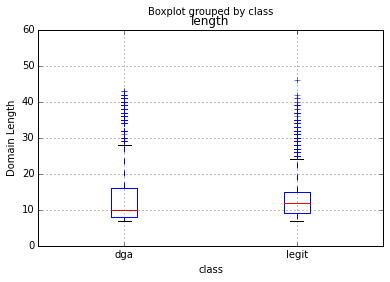

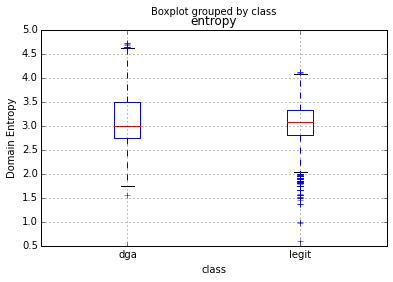

In [217]:
# Plot the length and entropy of domains
all_domains.boxplot('length','class')
plt.ylabel('Domain Length')
all_domains.boxplot('entropy','class')
plt.ylabel('Domain Entropy')

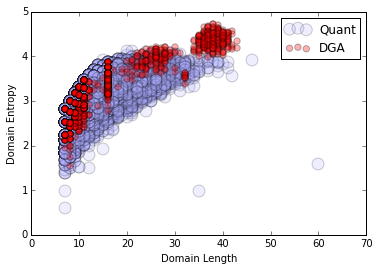

In [218]:
# Split the classes up so we can set colors, size, labels
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
alexa = all_domains[~cond]
plt.scatter(alexa['length'], alexa['entropy'], s=140, c='#aaaaff', label='Quant', alpha=.2)
plt.scatter(dga['length'], dga['entropy'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
plt.xlabel('Domain Length')
plt.ylabel('Domain Entropy')

# Below you can see that our DGA domains do tend to have higher entropy than Quant on average.

In [219]:
# Lets look at the types of domains that have entropy higher than 4
high_entropy_domains = all_domains[all_domains['entropy'] > 4]
print 'Num Domains above 4 entropy: %.2f%% %d (out of %d)' % \
            (100.0*high_entropy_domains.shape[0]/all_domains.shape[0],high_entropy_domains.shape[0],all_domains.shape[0])
print "Num high entropy legit: %d" % high_entropy_domains[high_entropy_domains['class']=='legit'].shape[0]
print "Num high entropy DGA: %d" % high_entropy_domains[high_entropy_domains['class']=='dga'].shape[0]
high_entropy_domains[high_entropy_domains['class']=='legit'].head()

# Looking at the results below, we do see that there are more domains
# in the DGA group that are high entropy but only a small percentage
# of the domains are in that high entropy range...

Num Domains above 4 entropy: 0.50% 381 (out of 76355)
Num high entropy legit: 23
Num high entropy DGA: 358


,domain,class,length,entropy
1943,campingworldofstaugustine,legit,25,4.003856
13675,email05-findyourfuturejob,legit,25,4.053661
16394,motorcycleconsumernews-digitalmagazine,legit,38,4.023472
17639,backporchquiltsanddesigns,legit,25,4.053661
21198,101hypnoticallyempoweringaffirmations,legit,37,4.121219


In [220]:
high_entropy_domains[high_entropy_domains['class']=='dga'].head()

,domain,class,length,entropy
85847,a17btkyb38gxe41pwd50nxmzjxiwjwdwfrp52,dga,37,4.540402
85848,a17c49l68ntkqnuhvkrmyb28fubvn30e31g43dq,dga,39,4.631305
85849,a17d60gtnxk47gskti15izhvlviyksh64nqkz,dga,37,4.270132
85850,a17erpzfzh64c69csi35bqgvp52drita67jzmy,dga,38,4.629249
85851,a17fro51oyk67b18ksfzoti55j36p32o11fvc29cr,dga,41,4.305859


In [221]:
# List of feature vectors (scikit learn uses 'X' for the matrix of feature vectors)
X = all_domains.as_matrix(['length', 'entropy'])

# Labels (scikit learn uses 'y' for classification labels)
y = np.array(all_domains['class'].tolist()) # Yes, this is weird but it needs 
                                            # to be an np.array of strings

In [222]:
import sklearn.ensemble
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20, compute_importances=True) # Trees in the forest

/Users/Ak/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:776: DeprecationWarning: Setting compute_importances is no longer required as version 0.14. Variable importances are now computed on the fly when accessing the feature_importances_ attribute. This parameter will be removed in 0.16.
  DeprecationWarning)


In [223]:
# Now we can use scikit learn's cross validation to assess predictive performance.
scores = sklearn.cross_validation.cross_val_score(clf, X, y, cv=5, n_jobs=4)
print scores

[ 0.97393924  0.97334992  0.97374108  0.97354289  0.97013752]


In [224]:
# Wow 97.4% accurate! At this point we could claim success but we will be and idiot.
# Recall that we have ~100k 'legit' domains and only 3.5k DGA domains
# So a classifier that marked everything as legit would be about
# 97.4% accurate....

# So we dive in a bit and look at the predictive performance more deeply.

# Train on a 80/20 split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Confusion Matrix Stats
legit/legit: 99.95% (14788/14795)
legit/dga: 0.05% (7/14795)
dga/legit: 83.82% (399/476)
dga/dga: 16.18% (77/476)


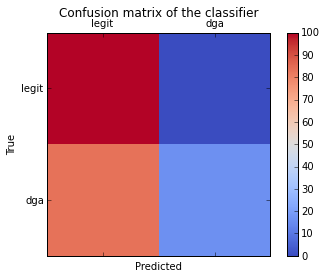

In [225]:
# Now plot the results of the 80/20 split in a confusion matrix
from sklearn.metrics import confusion_matrix
labels = ['legit', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)

def plot_cm(cm, labels):
    
    # Compute percentanges
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T)  # Derp, I'm sure there's a better way
    
    print 'Confusion Matrix Stats'
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print "%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum())

    # Show confusion matrix
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='coolwarm')
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_cm(cm, labels)

# We can see below that our suspicions were correct and the classifier is
# marking almost everything as Quant.

In [226]:
# Scikit learn has a nice NGram generator that can generate either char NGrams or word NGrams.
#       - ngram_range=(3,5)  # Give me all ngrams of length 3, 4, and 5
#       - min_df=1e-4        # Minimumum document frequency. At 1e-4 we're saying give us NGrams that 
#                            # happen in at least .1% of the domains (so for 100k... at least 100 domains)
quant_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-4, max_df=1.0)

In [227]:
counts_matrix = quant_vc.fit_transform(quant_df['domain'])
quant_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = quant_vc.get_feature_names()

In [228]:
import operator
_sorted_ngrams = sorted(zip(ngrams_list, quant_counts), key=operator.itemgetter(1), reverse=True)
print 'Quant NGrams: %d' % len(_sorted_ngrams)
for ngram, count in _sorted_ngrams[:10]:
    print ngram, count

Quant NGrams: 33313
ing 3.64923747235
ion 3.49803472369
ter 3.48869169832
ent 3.45969397648
the 3.44169513564
ers 3.43136376416
ine 3.4189638307
and 3.39462676427
tio 3.37694175715
lin 3.37493155398


In [229]:
word_df = pd.read_csv('words.txt', names=['word'], header=None, dtype={'word': np.str}, encoding='utf-8')

# Cleanup words from dictionary
word_df = word_df[word_df['word'].map(lambda x: str(x).isalpha())]
word_df = word_df.applymap(lambda x: str(x).strip().lower())
word_df = word_df.dropna()
word_df = word_df.drop_duplicates()
word_df.head(10)

,word
37,a
48,aa
51,aaa
53,aaaa
54,aaaaaa
55,aaal
56,aaas
57,aaberg
58,aachen
59,aae


In [230]:
# Now compute NGrams on the dictionary words
dict_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-5, max_df=1.0)
counts_matrix = dict_vc.fit_transform(word_df['word'])
dict_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = dict_vc.get_feature_names()

In [231]:
import operator
_sorted_ngrams = sorted(zip(ngrams_list, dict_counts), key=operator.itemgetter(1), reverse=True)
print 'Word NGrams: %d' % len(_sorted_ngrams)
for ngram, count in _sorted_ngrams[:10]:
    print ngram, count

Word NGrams: 123061
ing 4.38730082245
ess 4.20487933376
ati 4.19334725639
ion 4.16503647999
ter 4.16241503611
nes 4.11250445877
tio 4.07682242334
ate 4.07236020396
ent 4.06963110262
tion 4.04960561259


In [232]:
def ngram_count(domain):
    quant_match = quant_counts * quant_vc.transform([domain]).T  
    dict_match = dict_counts * dict_vc.transform([domain]).T
    print '%s Quant match:%d Dict match: %d' % (domain, quant_match, dict_match)

# Examples:
ngram_count('google')
ngram_count('facebook')
ngram_count('twitter')
ngram_count('engadget')

google Quant match:15 Dict match: 14
facebook Quant match:29 Dict match: 27
twitter Quant match:22 Dict match: 31
engadget Quant match:23 Dict match: 24


In [233]:
# Compute NGram matches for all the domains and add to our dataframe
all_domains['quant_grams']= quant_counts * quant_vc.transform(all_domains['domain']).T 
all_domains['word_grams']= dict_counts * dict_vc.transform(all_domains['domain']).T 
all_domains.head()

,domain,class,length,entropy,quant_grams,word_grams
0,hunchbacksynonumsantonums,legit,25,3.399080,78.308324,111.067816
1,hsselite,legit,8,2.500000,22.116580,30.626282
2,prycexrc,legit,8,2.500000,6.361082,8.170918
3,unitedfcu,legit,9,2.947703,25.974504,26.512890
4,gearbuyer,legit,9,2.725481,25.483371,23.944773


In [234]:
all_domains.tail()

,domain,class,length,entropy,quant_grams,word_grams
88222,ummvzhin,dga,8,2.750000,4.876657,7.180022
88223,umsgnwgc,dga,8,2.750000,3.447933,3.847079
88224,umzsbhpkrgo,dga,11,3.459432,1.886491,2.546543
88225,umzuyjrfwyf,dga,11,2.913977,0.000000,0.000000
88226,uohkxtp,dga,7,2.807355,0.000000,0.698970


In [235]:
all_domains['diff'] = all_domains['quant_grams'] - all_domains['word_grams']
all_domains.sort(['diff'], ascending=True).head(10)

# The table below shows those domain names that are more 'dictionary' and less 'web'

,domain,class,length,entropy,quant_grams,word_grams,diff
21198,101hypnoticallyempoweringaffirmations,legit,37,4.121219,146.535341,223.686344,-77.151003
61052,buildingorganizationalintelligence,legit,34,3.517343,174.052939,247.298325,-73.245387
8666,eliminateanyimpossibility,legit,25,3.383465,82.942788,151.533883,-68.591095
16806,sustainablepreparedness,legit,23,3.360306,94.767616,153.916019,-59.148403
53501,differentiatedkindergarten,legit,26,3.185667,104.487724,163.413105,-58.925382
51380,enlightened-consciousness,legit,25,3.443856,93.085682,151.052797,-57.967115
61165,christopherodonnellphotography,legit,30,3.669577,142.673877,200.184436,-57.510558
13063,saurornithesaurussynonumsantonums,legit,33,3.317312,111.027280,166.754987,-55.727706
16677,consciouslyenlightened,legit,22,3.572624,78.314682,133.873521,-55.558839
83761,channel4embarrassingillnesses,legit,29,3.440070,113.820327,169.119440,-55.299113


In [236]:
all_domains.sort(['diff'], ascending=False).head(50)

# The table below shows those domain names that are more 'web' and less 'dictionary'

,domain,class,length,entropy,quant_grams,word_grams,diff
32909,comcomcomcomcomcomcomcomcomcomcomcomcomcomcomc...,legit,60,1.584963,193.553372,117.501137,76.052235
16439,best-online-dating-tips,legit,23,3.522712,105.730131,68.910723,36.819408
81421,norton-online-scan-detected-security-error,legit,42,3.556756,175.658689,141.623543,34.035146
32636,tire-reviews-online,legit,19,3.260828,88.988559,55.493449,33.495110
6491,download-sheet-music-online,legit,27,3.754163,113.645058,80.311288,33.333770
34954,online-health-insurance,legit,23,3.534219,125.532658,92.923285,32.609374
32315,free-insurance-quotes-now,legit,25,3.623465,109.880764,77.582173,32.298591
66255,online-email-club,legit,17,3.337175,75.984155,43.847558,32.136597
31836,worldnewsdailyreport,legit,20,3.584184,100.920266,69.298715,31.621551
3096,cheap-auto-insurance-today,legit,26,3.748329,113.650475,82.279191,31.371284


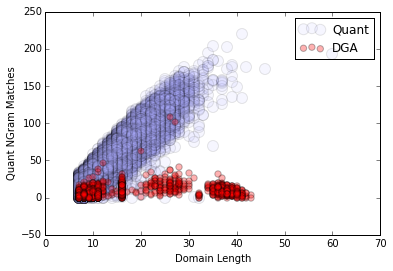

In [237]:
# Here we want to see whether our new 'quant_grams' feature can help us differentiate between Legit/DGA
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]
plt.scatter(legit['length'], legit['quant_grams'], s=120, c='#aaaaff', label='Quant', alpha=.1)
plt.scatter(dga['length'], dga['quant_grams'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
plt.xlabel('Domain Length')
plt.ylabel('Quant NGram Matches')

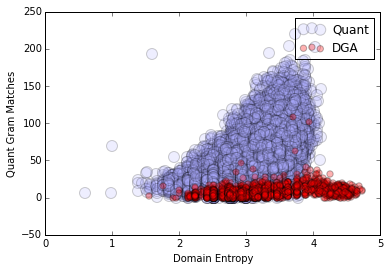

In [238]:
# Here we want to see whether our new 'quant_grams' feature can help us differentiate between Legit/DGA
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]
plt.scatter(legit['entropy'], legit['quant_grams'],  s=120, c='#aaaaff', label='Quant', alpha=.2)
plt.scatter(dga['entropy'], dga['quant_grams'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
plt.xlabel('Domain Entropy')
plt.ylabel('Quant Gram Matches')

In [239]:
# Lets look at which Legit domains are scoring low on the word gram count
all_domains[(all_domains['word_grams']==0)].head()

,domain,class,length,entropy,quant_grams,word_grams,diff
3120,1045snx,legit,7,2.807355,1.176091,0,1.176091
3130,krxt985,legit,7,2.807355,0.000000,0,0.000000
3155,rmx00o1,legit,7,2.521641,0.000000,0,0.000000
3474,mkt5763,legit,7,2.807355,4.286681,0,4.286681
5175,cjo-cdn,legit,7,2.521641,6.883321,0,6.883321


In [240]:
all_domains[all_domains['class']=='legit'].describe()

,length,entropy,quant_grams,word_grams,diff
count,73957.000000,73957.000000,73957.000000,73957.000000,73957.000000
mean,12.657193,3.056113,46.178313,52.967128,-6.788815
std,4.207832,0.345835,25.181373,28.625952,8.744009
min,7.000000,0.591673,0.000000,0.000000,-77.151003
25%,9.000000,2.807355,27.062013,31.677846,-11.760264
50%,12.000000,3.085055,41.816186,48.239249,-6.333153
75%,15.000000,3.321928,60.790660,69.420983,-1.369443
max,60.000000,4.121928,219.222408,247.298325,76.052235


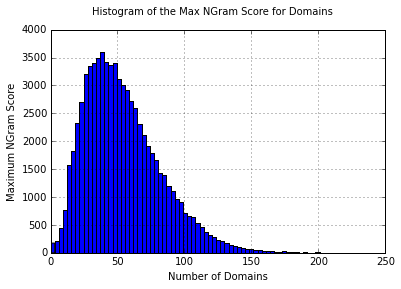

In [241]:
# Lets look at how many domains that are both low in word_grams and quant_grams (just plotting the max of either)
legit = all_domains[(all_domains['class']=='legit')]
max_grams = np.maximum(legit['quant_grams'],legit['word_grams'])
ax = max_grams.hist(bins=80)
ax.figure.suptitle('Histogram of the Max NGram Score for Domains')
plt.xlabel('Number of Domains')
plt.ylabel('Maximum NGram Score')

In [243]:
# Lets look at which Legit domains are scoring low on both alexa and word gram count
weird_cond = (all_domains['class']=='legit') & (all_domains['word_grams']<3) & (all_domains['quant_grams']<2)
weird = all_domains[weird_cond]
print weird.shape[0]
weird.head(30)

136


,domain,class,length,entropy,quant_grams,word_grams,diff
2061,790waeb,legit,7,2.807355,0.000000,2.357935,-2.357935
2125,6y7eiv6v,legit,8,2.500000,0.000000,2.190332,-2.190332
3120,1045snx,legit,7,2.807355,1.176091,0.000000,1.176091
3130,krxt985,legit,7,2.807355,0.000000,0.000000,0.000000
3155,rmx00o1,legit,7,2.521641,0.000000,0.000000,0.000000
3925,6r2uvllu,legit,8,2.500000,1.903090,2.917506,-1.014416
5238,mkt1311,legit,7,2.128085,1.934498,0.000000,1.934498
7259,mkt1447,legit,7,2.521641,1.934498,0.000000,1.934498
8333,aq2qzskc,legit,8,2.750000,0.000000,0.000000,0.000000
9158,mkt4468,legit,7,2.521641,1.934498,0.000000,1.934498


In [244]:
all_domains.loc[weird_cond, 'class'] = 'weird'
print all_domains['class'].value_counts()
all_domains[all_domains['class'] == 'weird'].head()

legit    73821
dga       2398
weird      136
dtype: int64


,domain,class,length,entropy,quant_grams,word_grams,diff
2061,790waeb,weird,7,2.807355,0.000000,2.357935,-2.357935
2125,6y7eiv6v,weird,8,2.500000,0.000000,2.190332,-2.190332
3120,1045snx,weird,7,2.807355,1.176091,0.000000,1.176091
3130,krxt985,weird,7,2.807355,0.000000,0.000000,0.000000
3155,rmx00o1,weird,7,2.521641,0.000000,0.000000,0.000000


In [245]:
# Now we try our machine learning algorithm again with the new features
# Quant and Dictionary NGrams and the exclusion of the bad exemplars.
X = all_domains.as_matrix(['length', 'entropy', 'quant_grams', 'word_grams'])

# Labels (scikit learn uses 'y' for classification labels)
y = np.array(all_domains['class'].tolist())

# Train on a 80/20 split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Confusion Matrix Stats
legit/legit: 99.51% (14715/14787)
legit/weird: 0.00% (0/14787)
legit/dga: 0.49% (72/14787)
weird/legit: 0.00% (0/28)
weird/weird: 21.43% (6/28)
weird/dga: 78.57% (22/28)
dga/legit: 14.47% (66/456)
dga/weird: 1.32% (6/456)
dga/dga: 84.21% (384/456)


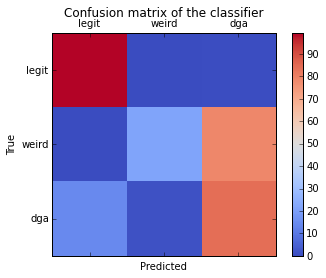

In [246]:

# Now plot the results of the 80/20 split in a confusion matrix
labels = ['legit', 'weird', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels)

In [247]:
# Well that seem to work 'ok', but you don't really want a classifier
# that outputs 3 classes, you'd like a classifier that flags domains as DGA or not.
# This was a path that seemed like a good idea until it wasn't....

In [249]:
# Perhaps we will just exclude the weird class from our ML training
not_weird = all_domains[all_domains['class'] != 'weird']
X = not_weird.as_matrix(['length', 'entropy', 'quant_grams', 'word_grams'])

# Labels (scikit learn uses 'y' for classification labels)
y = np.array(not_weird['class'].tolist())

# Train on a 80/20 split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Confusion Matrix Stats
legit/legit: 99.61% (14706/14764)
legit/dga: 0.39% (58/14764)
dga/legit: 15.83% (76/480)
dga/dga: 84.17% (404/480)


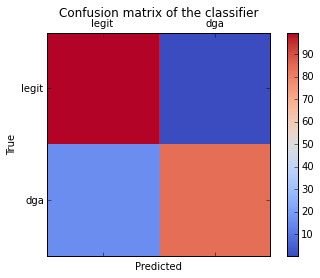

In [250]:
# Now plot the results of the 80/20 split in a confusion matrix
labels = ['legit', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels) 

In [251]:
# First train on the whole thing before looking at prediction performance
clf.fit(X, y)

hold_out_domains = pd.concat([hold_out_quant, hold_out_dga], ignore_index=True)

# Add a length field for the domain
hold_out_domains['length'] = [len(x) for x in hold_out_domains['domain']]
hold_out_domains = hold_out_domains[hold_out_domains['length'] > 6]

# Add a entropy field for the domain
hold_out_domains['entropy'] = [entropy(x) for x in hold_out_domains['domain']]

# Compute NGram matches for all the domains and add to our dataframe
hold_out_domains['quant_grams']= quant_counts * quant_vc.transform(hold_out_domains['domain']).T
hold_out_domains['word_grams']= dict_counts * dict_vc.transform(hold_out_domains['domain']).T

hold_out_domains.head()

,domain,class,length,entropy,quant_grams,word_grams
0,olderdummy,legit,10,2.921928,23.541547,36.012258
1,wisconline,legit,10,2.921928,49.590325,45.491861
2,communitybible,legit,14,3.378783,64.371721,64.818168
3,ask-leo,legit,7,2.807355,5.616575,5.294164
5,diamondresortsandhotels,legit,23,3.468577,116.209000,110.475371


Confusion Matrix Stats
legit/legit: 99.35% (8196/8250)
legit/dga: 0.65% (54/8250)
dga/legit: 14.29% (38/266)
dga/dga: 85.71% (228/266)


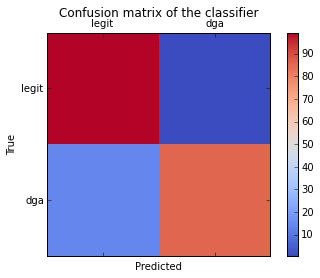

In [252]:
# List of feature vectors (scikit learn uses 'X' for the matrix of feature vectors)
hold_X = hold_out_domains.as_matrix(['length', 'entropy', 'quant_grams', 'word_grams'])

# Labels (scikit learn uses 'y' for classification labels)
hold_y = np.array(hold_out_domains['class'].tolist())

# Now run through the predictive model
hold_y_pred = clf.predict(hold_X)

# Add the prediction array to the dataframe
hold_out_domains['pred'] = hold_y_pred

# Now plot the results
labels = ['legit', 'dga']
cm = confusion_matrix(hold_y, hold_y_pred, labels)
plot_cm(cm, labels) 

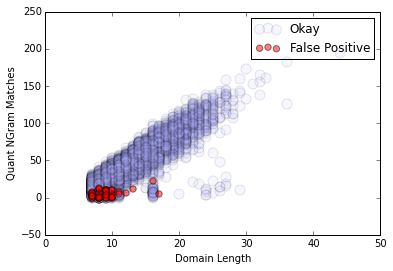

In [254]:
# Okay so our 10% hold out set of 10k domains about ~100 domains were mis-classified
# at this point we're made some good progress.
#       - Out of 10k domains 75 were mismarked
#       - false positives (Quant marked as DGA) = ~0.7%
#       - about 85% of the DGA are getting marked


# Now were going to just do some post analysis on how the ML algorithm performed.

# Lets look at a couple of plots to see which domains were misclassified.
# Looking at Length vs. Quant NGrams
fp_cond = ((hold_out_domains['class'] == 'legit') & (hold_out_domains['pred']=='dga'))
fp = hold_out_domains[fp_cond]
fn_cond = ((hold_out_domains['class'] == 'dba') & (hold_out_domains['pred']=='legit'))
fn = hold_out_domains[fn_cond]
okay = hold_out_domains[hold_out_domains['class'] == hold_out_domains['pred']]
plt.scatter(okay['length'], okay['quant_grams'], s=100,  c='#aaaaff', label='Okay', alpha=.1)
plt.scatter(fp['length'], fp['quant_grams'], s=40, c='r', label='False Positive', alpha=.5)
plt.legend()
plt.xlabel('Domain Length')
plt.ylabel('Quant NGram Matches')

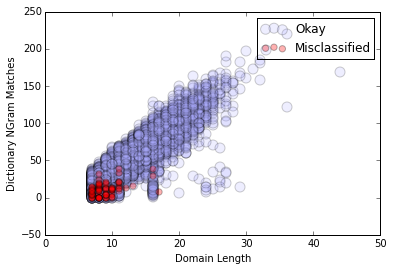

In [255]:
# Looking at Length vs. Dictionary NGrams
cond = (hold_out_domains['class'] != hold_out_domains['pred'])
misclassified = hold_out_domains[cond]
okay = hold_out_domains[~cond]
plt.scatter(okay['length'], okay['word_grams'], s=100,  c='#aaaaff', label='Okay', alpha=.2)
plt.scatter(misclassified['length'], misclassified['word_grams'], s=40, c='r', label='Misclassified', alpha=.3)
plt.legend()
plt.xlabel('Domain Length')
plt.ylabel('Dictionary NGram Matches')

In [256]:
misclassified.head()

,domain,class,length,entropy,quant_grams,word_grams,pred
361,4505meats,legit,9,2.947703,10.519292,13.167530,dga
501,aayam2013,legit,9,2.641604,5.229753,5.489241,dga
766,mo8mwxi1,legit,8,2.750000,0.000000,0.000000,dga
885,cs-vltd,legit,7,2.807355,3.477121,0.778151,dga
981,gr2hk6ze,legit,8,3.000000,0.000000,0.000000,dga


In [257]:
misclassified[misclassified['class'] == 'dga'].head()

,domain,class,length,entropy,quant_grams,word_grams,pred
9549,ushcnewo,dga,8,3.000000,13.768656,13.904812,legit
9554,utamehz,dga,7,2.807355,10.204712,14.733893,legit
9556,utfowept,dga,8,2.750000,8.165913,16.814295,legit
9561,uufoxtek,dga,8,2.750000,8.037974,9.812391,legit
9567,uvhctmngf,dga,9,3.169925,4.674402,3.217484,legit


In [259]:
importances = zip(['length', 'entropy', 'quant_grams', 'word_grams'], clf.feature_importances_)
importances

# From the list below we see our feature importance scores. 

[('length', 0.11523133934258718),
 ('entropy', 0.14731334920741262),
 ('quant_grams', 0.54592011390731887),
 ('word_grams', 0.19153519754268136)]

In [260]:
# Typically Machine Learning comes in two phases
#    - Training of the Model
#    - Evaluation of new observations against the Model

# In this case we'd have to pick the RandomForest classifier
# and the two vectorizing transforms (quant_grams and word_grams).

def test_it(domain):
    
    _quant_match = quant_counts * quant_vc.transform([domain]).T 
    _dict_match = dict_counts * dict_vc.transform([domain]).T
    _X = [len(domain), entropy(domain), _quant_match, _dict_match]
    print '%s : %s' % (domain, clf.predict(_X)[0])

In [267]:
test_it('twitter')
test_it('linkdIn')
test_it('gulte')
test_it('980ahfafi239')
test_it('itsnotthere')
test_it('isthereawebsitenamedwebsite')
test_it('34jksdo45sf')

twitter : legit
linkdIn : legit
gulte : legit
980ahfafi239 : dga
itsnotthere : legit
isthereawebsitenamedwebsite : legit
34jksdo45sf : dga
